In [21]:
import pandas as pd
import numpy as np
from bayes_approach import Bayesian_AB
import numpy as np
import arviz as az
from dotenv import load_dotenv

load_dotenv()

True

In [22]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [23]:
query = '''
with precondition as (
    SELECT
    	DISTINCT(s.session_id) as session_id
    FROM
    	HEYCAR.MARKETING m
    JOIN
        HEYCAR.SESSION s on m.CAMPAIGN_NAME = s.MKT_CAMPAIGN_NAME
    WHERE
    	m.CAMPAIGN_NAME in ('DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_OCT','DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_WOW_OCT')
        AND s.session_day between '2022-11-20' and '2022-12-30'
        AND s.platform_id = 0
        --AND s.device_type in ('desktop', 'tablet')
        AND (s.is_bot is null OR s.is_bot = 0)
        --AND s.has_tracking_consent = 1
        AND s.country_code = 'de'      
), sessions as (
	SELECT
		s.session_id,
		s.session_day,
		s.MKT_CAMPAIGN_NAME as test_group
    FROM
        HEYCAR.SESSION s
    WHERE
    	s.session_day between '2022-11-25' and '2022-12-15'
        --AND s.device_type in ('desktop', 'tablet')
        AND (s.is_bot is null OR s.is_bot = 0)
        --AND s.has_tracking_consent = 1
        AND s.country_code = 'de'
        AND s.session_id in (SELECT session_id FROM precondition)
    GROUP BY
    	1, 2, 3
), leads as (
	SELECT
		sl.session_id,
		sl.session_day,
		1 as leads
	FROM
		HEYCAR.SESSION_LEAD_LOOKUP sl
    JOIN
        HEYCAR.LEAD l on sl.lead_id = l.lead_id
	WHERE
        sl.session_day between '2022-11-20' and '2022-12-30'
        AND sl.country_code = 'de' 
        AND l.IS_QUALITY_LEAD = 1
    GROUP BY
        1, 2
)
SELECT
    s.session_id,
	s.session_day,
	s.test_group,
	nvl(l.leads, 0) as leads
FROM
	sessions s
LEFT JOIN
	leads l on s.session_id = l.session_id
'''

In [24]:
E = Bayesian_AB(project_name='Listing_score_phase_2_stat_result')

In [25]:
df = E.get_data(load_new=True, query=query)
df

/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,session_id,session_day,test_group,leads
0,ajs-next-5c18b36eb2b3ee6d9e2957d61456888b,2022-12-08,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_OCT,1
1,ajs-next-bdbbec8b4547c53de1739fe5fa22ef30,2022-11-30,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_WOW_OCT,1
2,ajs-next-2c47744886fc50af89b50c70f9e7ad87,2022-11-29,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_WOW_OCT,1
3,ajs-next-ef1878e12b150c7d7703e36fd6322bfe,2022-12-10,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_WOW_OCT,1
4,ajs-next-19f9e4a750ef093aea859fbb6653fda6,2022-11-26,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_OCT,1
...,...,...,...,...
197202,ajs-next-380a727d7867dbd44911302b0bab3371,2022-11-28,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_WOW_OCT,0
197203,ajs-next-37b566fcfa3b3c56ef457996973142e8,2022-12-02,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_OCT,0
197204,ajs-next-4429fed1131670dea659870778de12fe,2022-11-26,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_OCT,0
197205,ajs-next-f28cdcd030655da3f4d8b2e5ed2c572a,2022-12-13,DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_OCT,0


In [26]:
c, v = E.prepare_data(df,
                      control_filter='DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_HOTNESS_OCT',
                      variant_filter='DE_PS_PRO_CLS_CATALOGS_DYNAMIC_TEST_WOW_OCT',
                      date_column='session_day',
                      sample_column='session_id',
                      conversion_column='leads',
                      test_column='test_group',
                      day_index=True
                     ) 
#control group & variant group

In [27]:
c #control (desktop)

,DATE,WEEK_DAY,session_id,leads
DAY,,,,
0,2022-11-25,Friday,4285,4
1,2022-11-26,Saturday,5099,4
2,2022-11-27,Sunday,5328,3
3,2022-11-28,Monday,4807,1
4,2022-11-29,Tuesday,5062,3
5,2022-11-30,Wednesday,5282,3
6,2022-12-01,Thursday,5437,5
7,2022-12-02,Friday,5244,2
8,2022-12-03,Saturday,6853,4


In [28]:
v #variant (desktop)

,DATE,WEEK_DAY,session_id,leads
DAY,,,,
0,2022-11-25,Friday,3337,11
1,2022-11-26,Saturday,3996,5
2,2022-11-27,Sunday,4274,7
3,2022-11-28,Monday,3772,9
4,2022-11-29,Tuesday,3869,8
5,2022-11-30,Wednesday,3779,9
6,2022-12-01,Thursday,4570,4
7,2022-12-02,Friday,4369,6
8,2022-12-03,Saturday,5488,8


In [29]:
simulation_ImSa = E.posterior_analytic_importance_sampling(control=c,
                                                           variant=v)

/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/datnguyen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_di

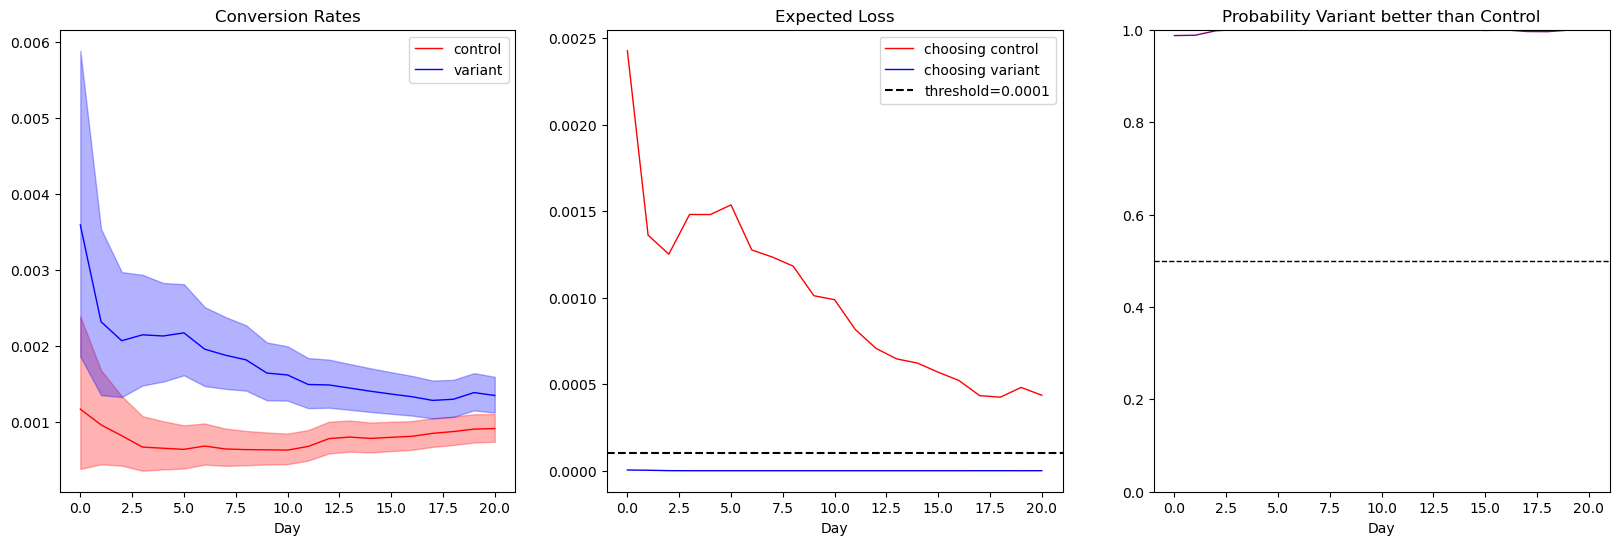

In [30]:
E.plot_expected_loss(simulation_ImSa)

In [31]:
E.get_results()

VALUE
GROUP   METRIC                                       
control CvR                                   0.00091
        sample size                            104350
        conversions                                94
        95% credible interval      (0.00074, 0.00110)
variant CvR                                   0.00135
        sample size                             92857
        conversions                               124
        95% credible interval      (0.00112, 0.00159)
outcome uplift                                47.864%
        control expected loss                0.000436
        variant expected loss                     0.0
        prob (variant >= control)             99.885%
        standard error                       0.000567

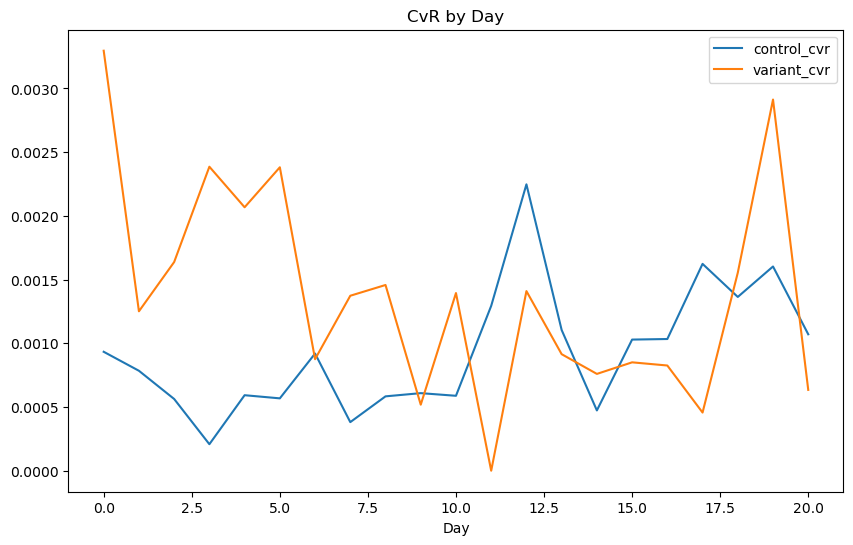

In [32]:
E.plot_lines(c, v)